In [1]:
import os, sys
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools
import collections

sys.path.append('../../')
from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

<module 'easi_fish.intensity' from '/u/project/zipursky/f7xiesnm/code/easifish-proc/bydatasets/sparse06/../../easi_fish/intensity.py'>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

sns.set_style('white', rc={'axes.grid':True})
sns.set_context('talk')

Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize

### On units
- all images are based on pixel units - 
- roi meta file (output) are based on physical unit (um - pre-expansion)
- spots files are in um (post-expansion)

In [4]:
ddir = '/u/home/f/f7xiesnm/project-zipursky/easifish/sparse06'
output_dir = ddir + '/proc/r1_flatfield'
!mkdir -p $output_dir
!ls $output_dir

In [14]:
## input

# theround = 'r2'
# rounds = [theround]
# channels = ['c0', 'c1', 'c2', 'c4']


fix_round = 'r1_flatfield'
mov_rounds = [] #['r2', 'r6', 'r7']
round_channels = collections.OrderedDict({
    'r1': ('c0', 'c2', 'c4'),
})

dapi_channel = 'c3'
lb_scale = 's3'
lb_res = [1.84,1.84,1.68]
ex = 2

# images
fix_dir  =  ddir + f"/outputs/{fix_round}/stitching/export.n5"
lb_dir  =   ddir + f"/outputs/{fix_round}/segmentation/{fix_round}-{dapi_channel}.tif"
reg_dirs = []
# reg_dirs = [
#     ddir + f"/outputs/r2/registration/usable/r2-to-r1/warped",
#     ddir + f"/outputs/r7/registration/usable/r7-to-r1/warped",
#     ]
subpath =   f'/{dapi_channel}/{lb_scale}' 


# spot dir for every gene
fx_spots = [
    ddir + f'/outputs/r1_flatfield/v2/spots/spots_c0.txt',
    ddir + f'/outputs/r1_flatfield/v2/spots/spots_c00.txt',
]


intn_threshs = [
    150, 
    150, 
    150, 
]
    
for f in fx_spots:
    assert os.path.isfile(f)

## output
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")

In [15]:
df1 = pd.read_csv(fx_spots[0], header=None)
df1

0           1           2         3
0       16.072446   41.097459    6.300000  181.5752
1       23.309442   28.471333   10.882452  165.8014
2       12.208722   41.997863   11.186448  151.0045
3        9.276498   42.394475   13.964790  189.6735
4       10.109190   42.001727   12.609912  146.8497
...           ...         ...         ...       ...
32936  416.803064  424.548314  163.364161  238.7692
32937  417.747076  426.296452  158.797417  153.4872
32938  417.283718  428.728656  158.512741  251.7901
32939  417.790040  426.439880  159.421453  179.0688
32940  418.139410  427.880876  162.329659  265.1074

[32941 rows x 4 columns]

In [16]:
df2 = pd.read_csv(fx_spots[1], header=None)
df2

0           1           2         3
0       16.074102   41.098977    6.291516  177.5831
1       23.304198   28.470321   10.799670  155.9566
2       12.050528   41.971643   11.013534  142.9358
3       10.228468   41.956371   12.606426  144.7890
4       12.186228   42.014699   11.190774  148.4453
...           ...         ...         ...       ...
24088  407.524219  433.306024  166.027213  191.8665
24089  411.755989  437.962052  157.882363  144.5557
24090  417.490350  421.397314  159.131107  190.3754
24091  419.598760  424.530926  158.016133  163.7920
24092  414.843694  436.494468  157.337077  132.9514

[24093 rows x 4 columns]

<Axes: xlabel='3', ylabel='Count'>

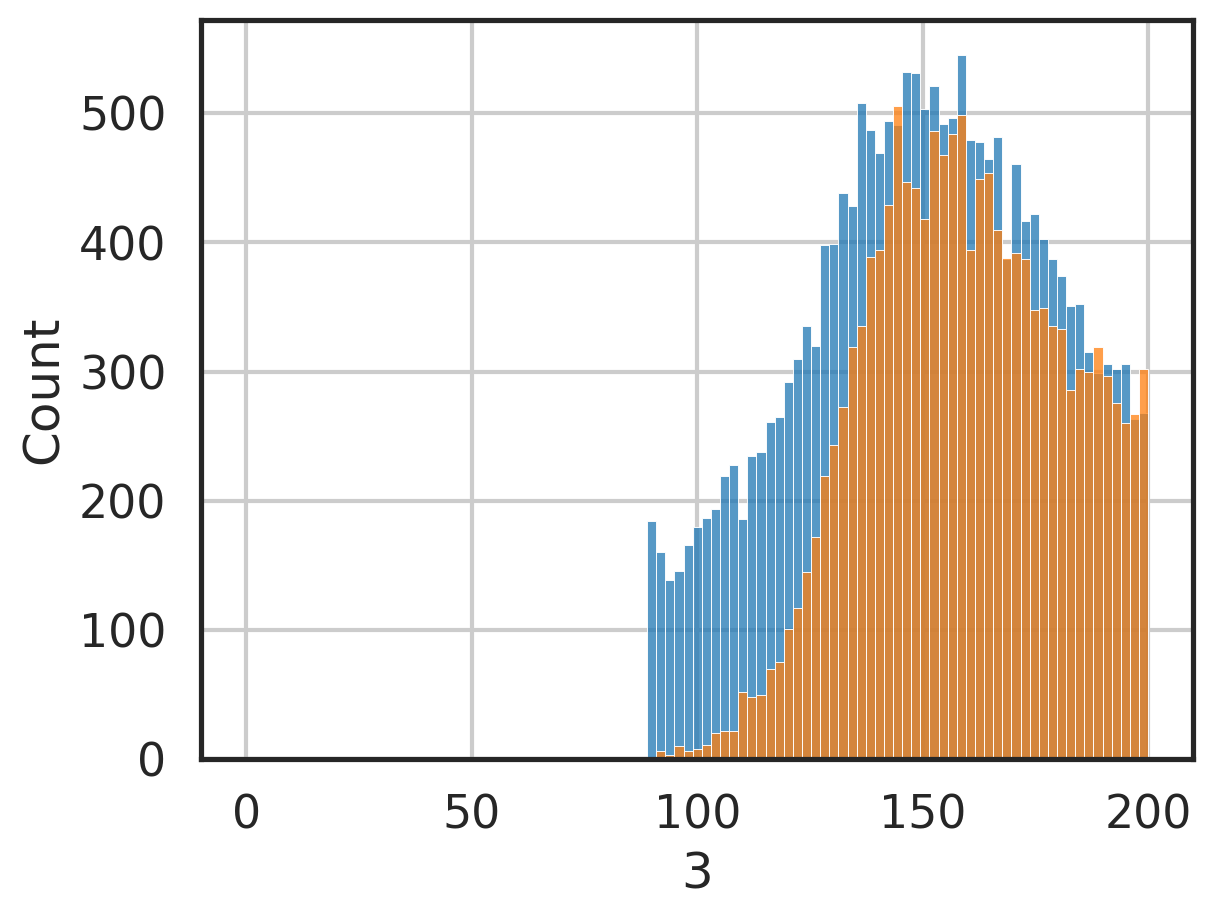

In [17]:
bins = np.linspace(0, 200, 100)
sns.histplot(df1[3], bins=bins)
sns.histplot(df2[3], bins=bins)

In [22]:
# df1sub = df1[df1[3]<120]

In [26]:
th = 150
df1 = df1[df1[3] > th]
print(df1.shape)
df2 = df2[df2[3] > th]
print(df2.shape)

(23373, 4)
(19052, 4)


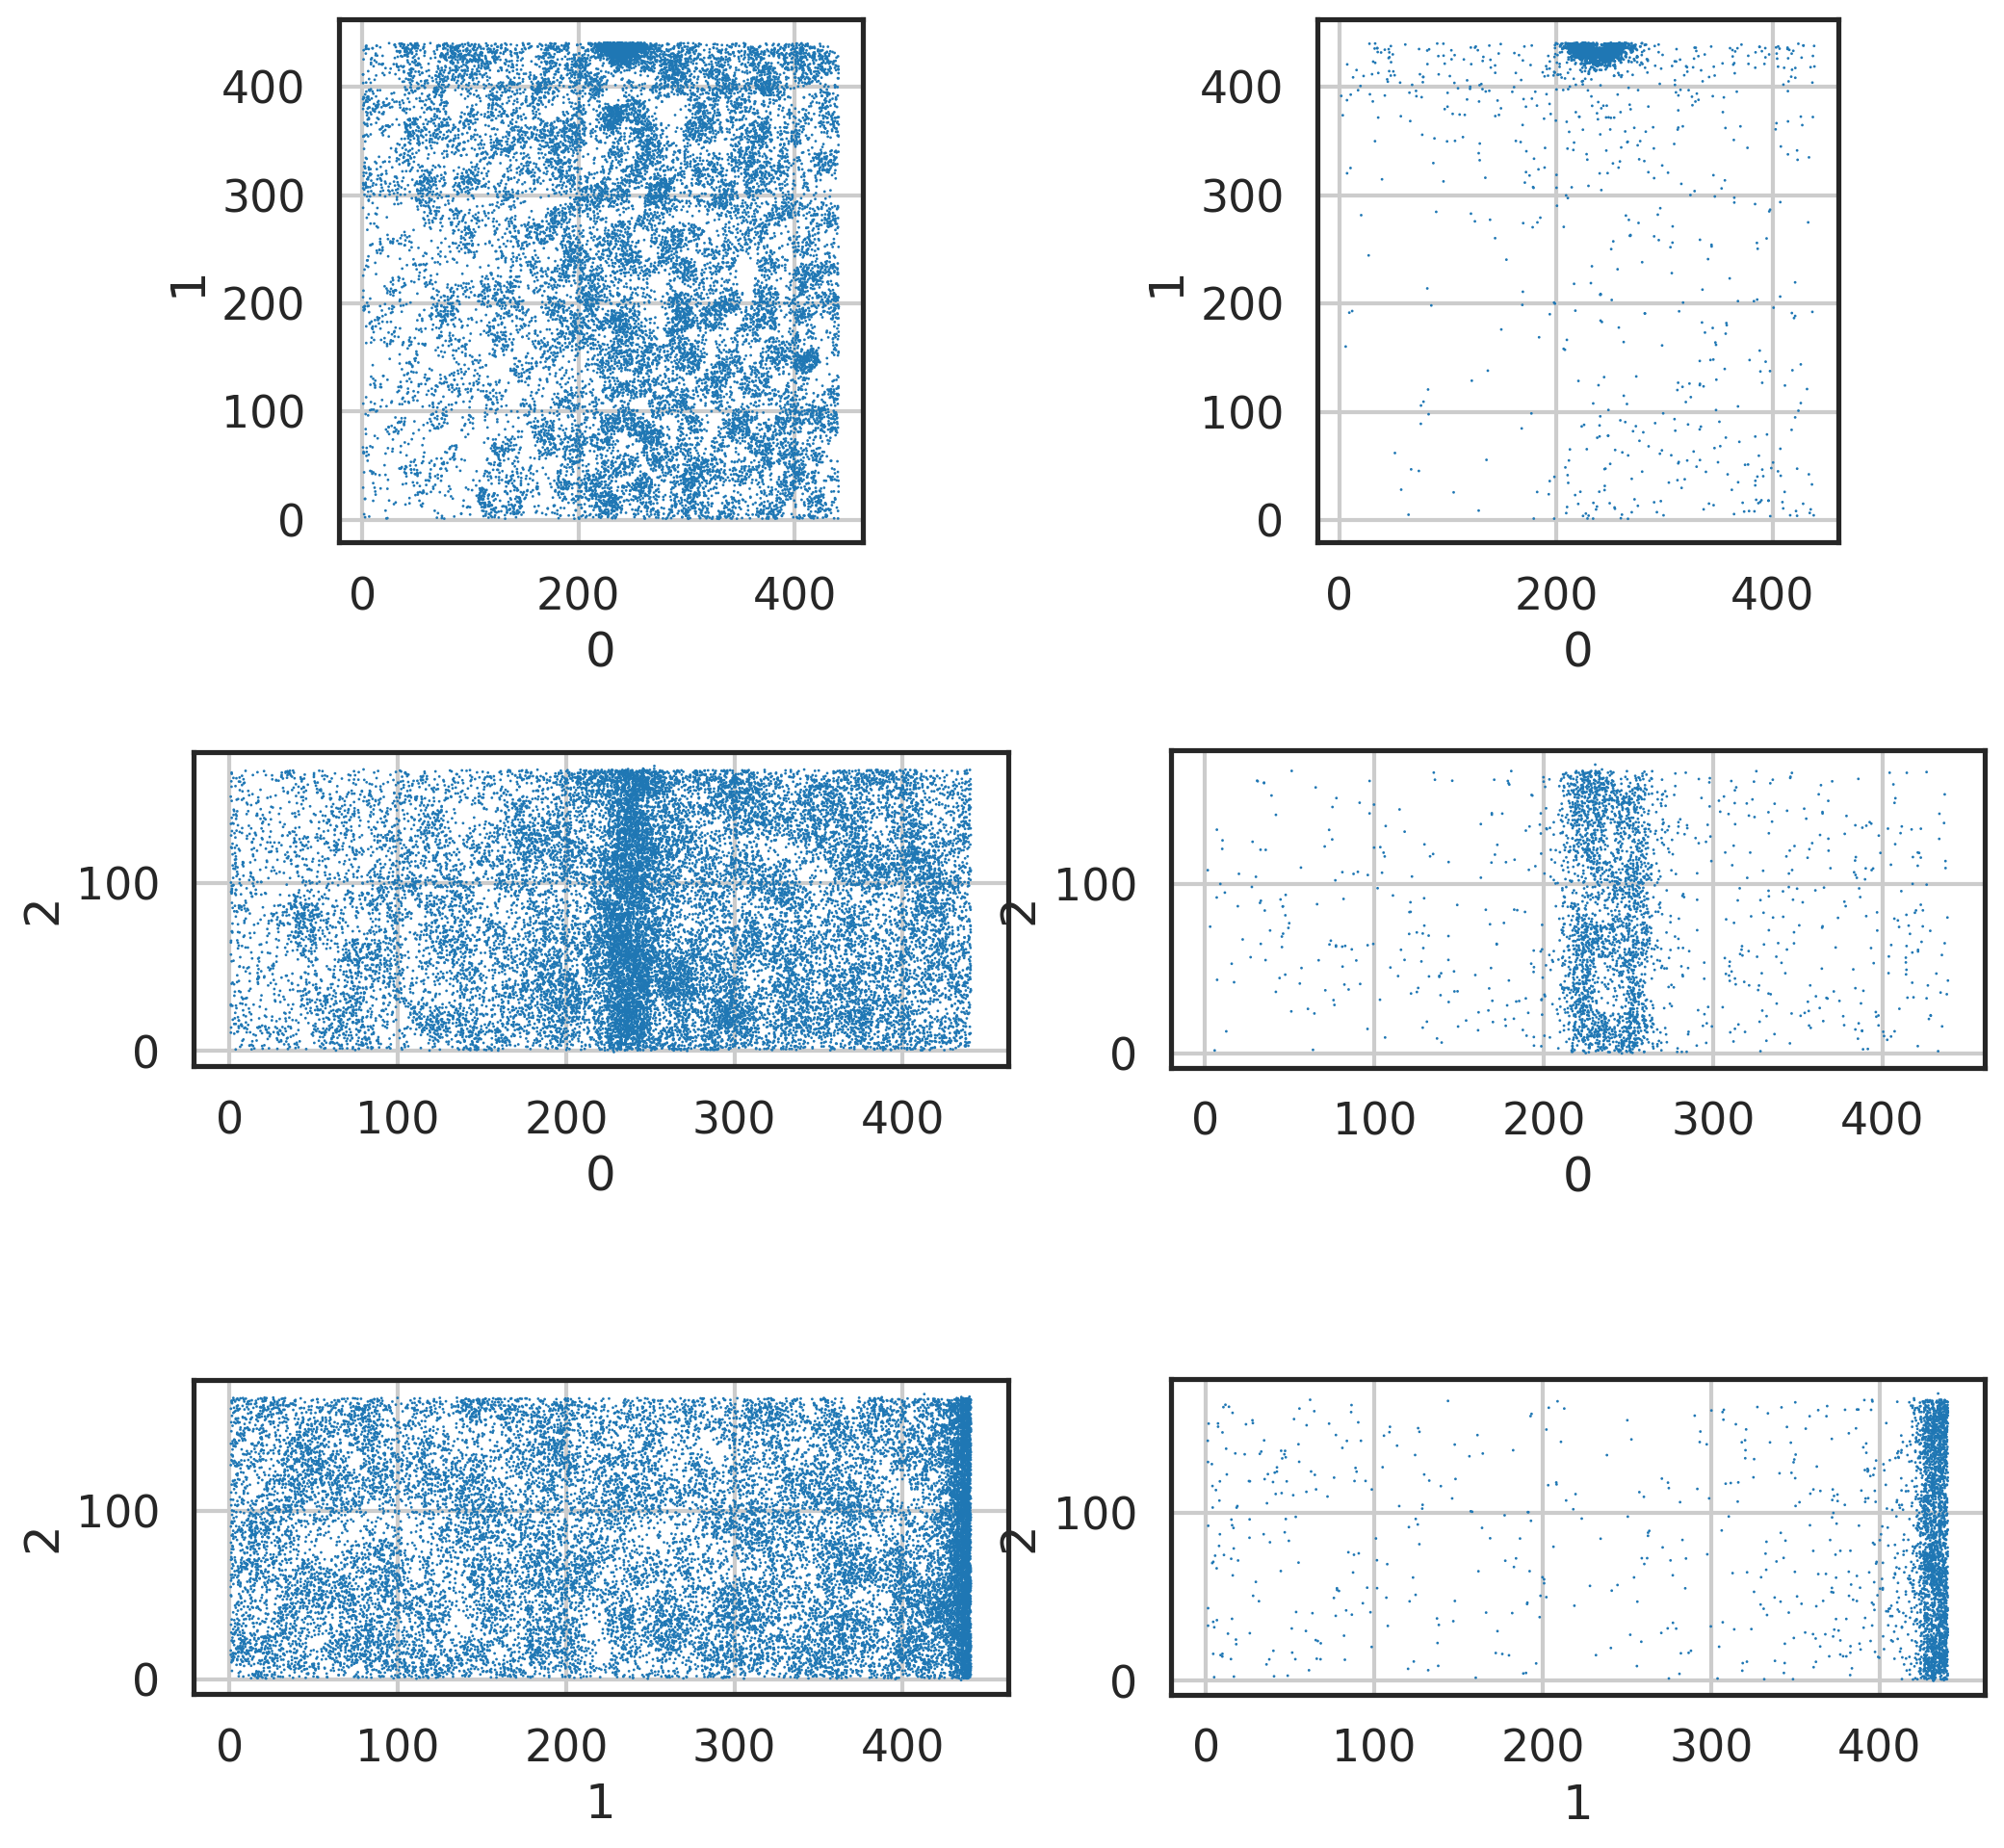

In [27]:
fig, axs = plt.subplots(3,2,figsize=(2*6,3*4))
ax = axs[0,0]
sns.scatterplot(data=df1, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[0,1]
sns.scatterplot(data=df1sub, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[1,0]
sns.scatterplot(data=df1, x=0, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[1,1]
sns.scatterplot(data=df1sub, x=0, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[2,0]
sns.scatterplot(data=df1, x=1, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[2,1]
sns.scatterplot(data=df1sub, x=1, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')

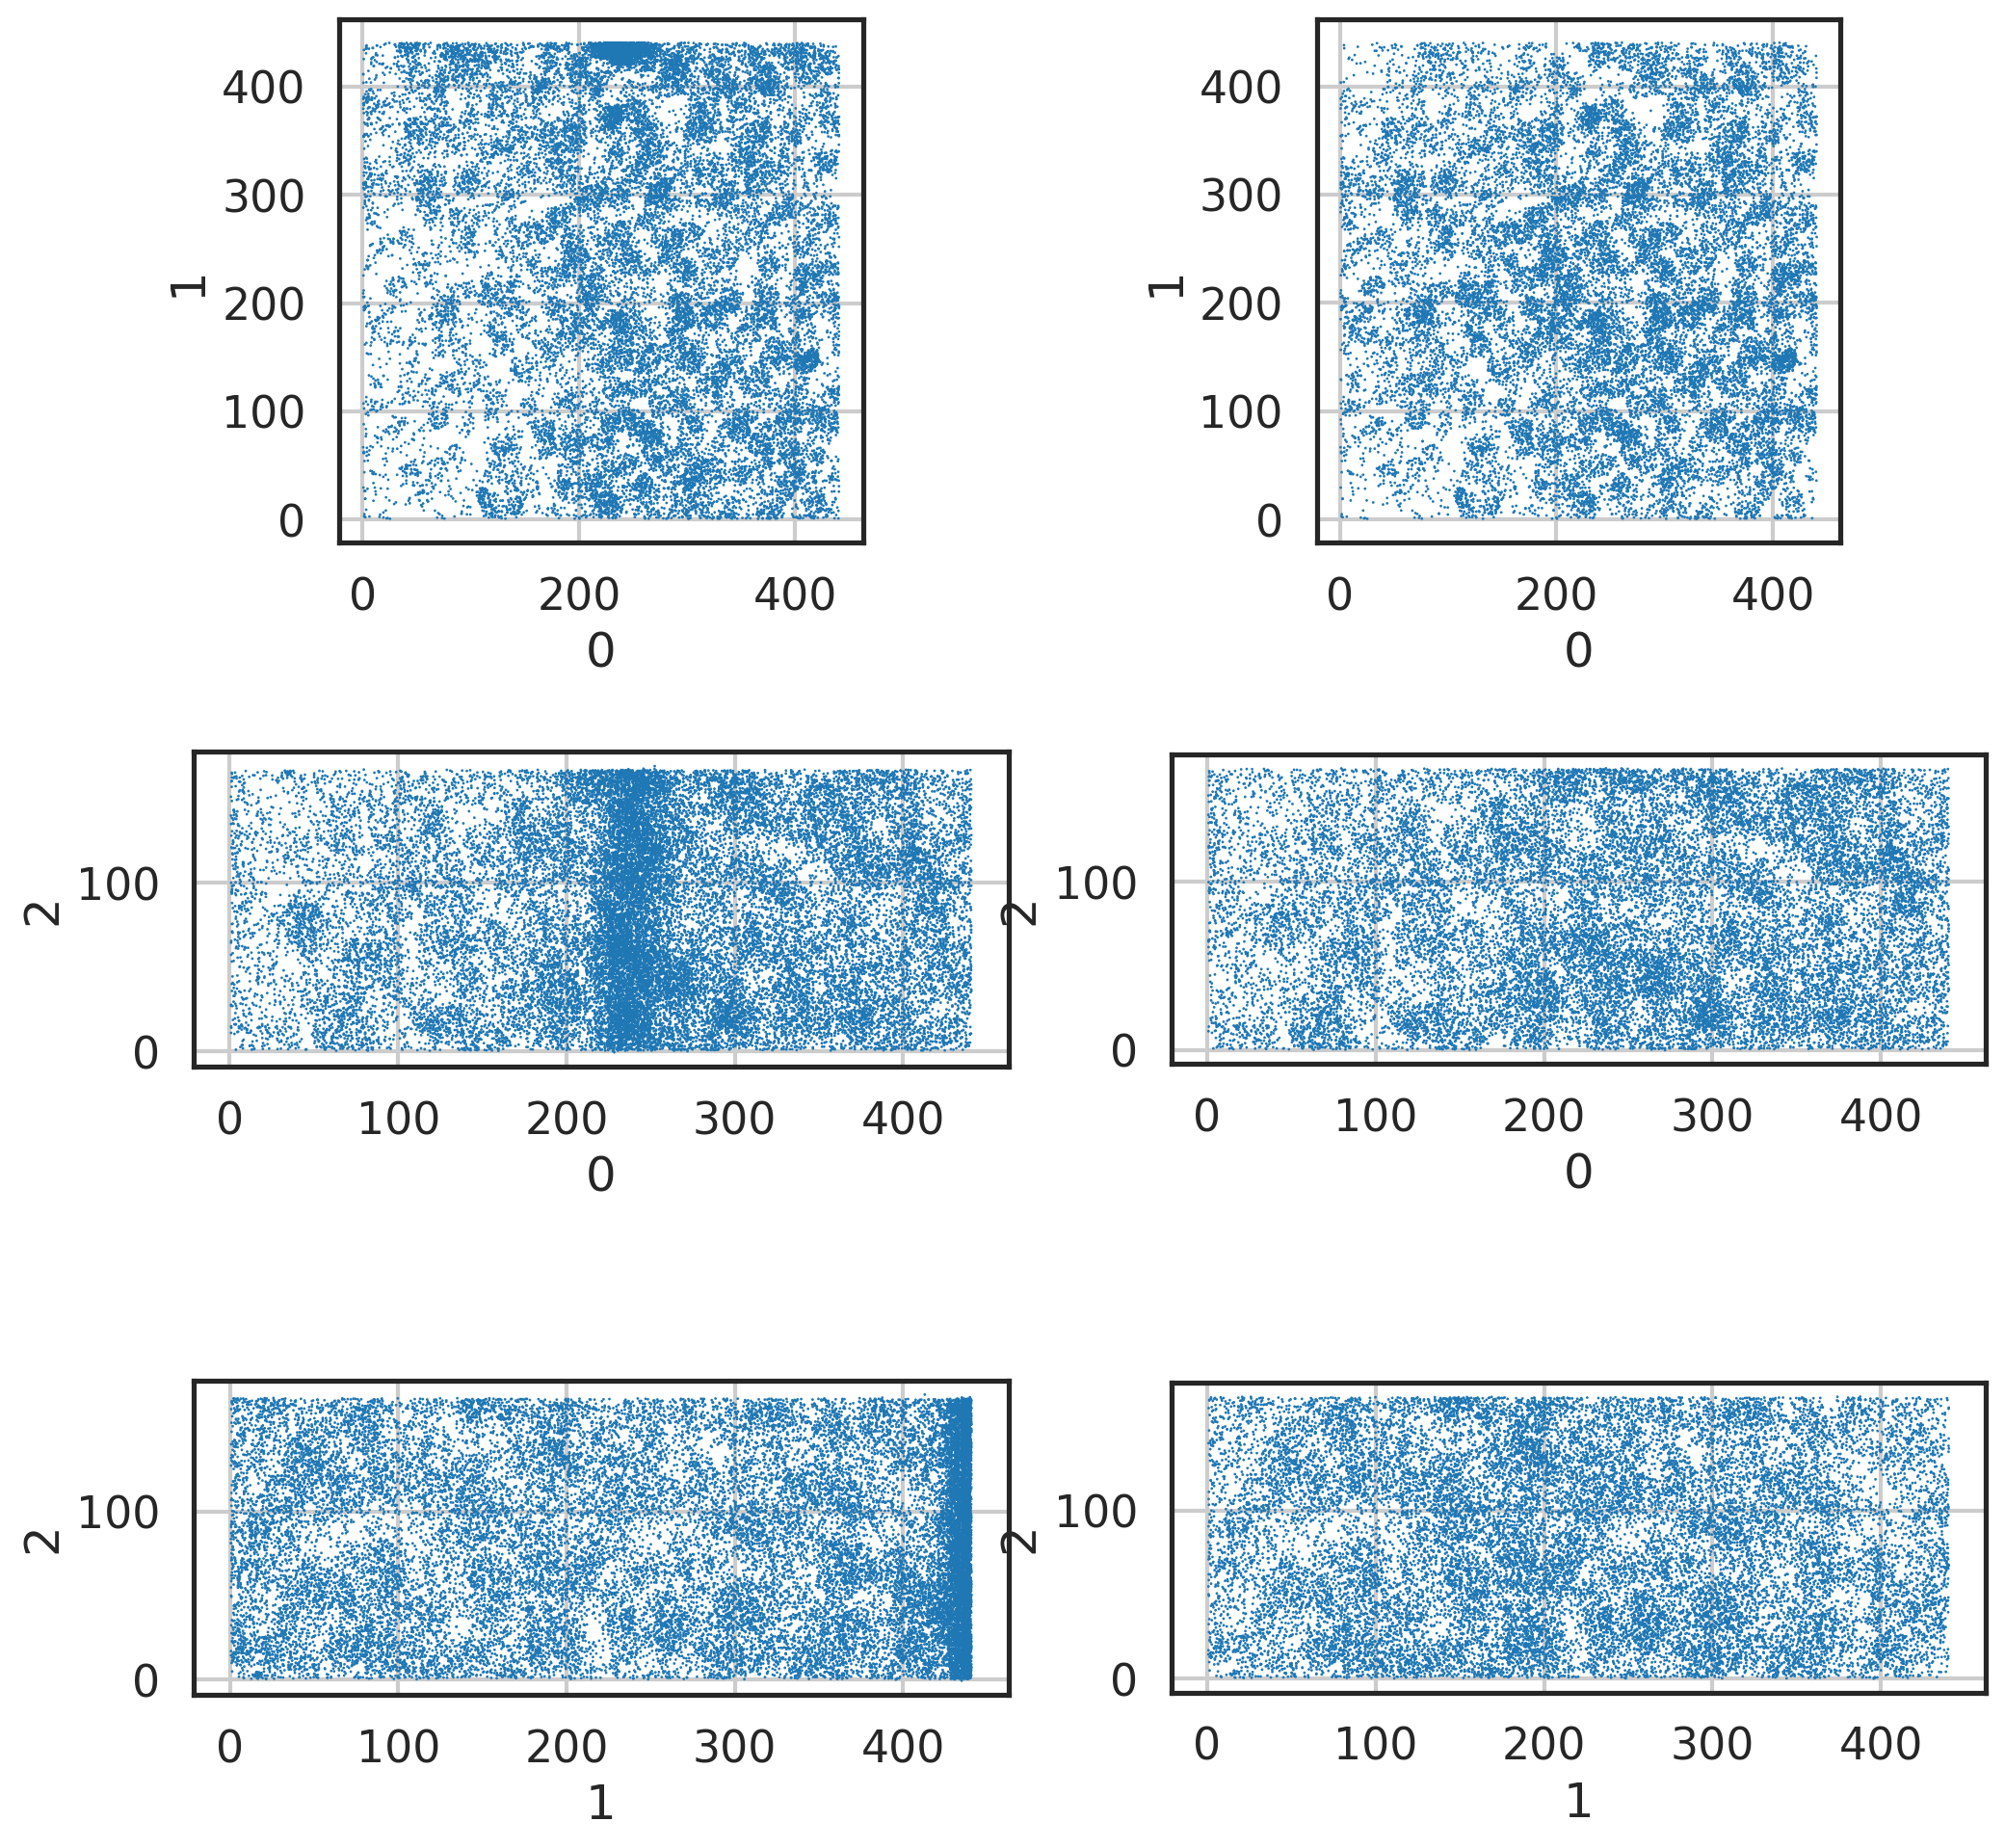

In [25]:
fig, axs = plt.subplots(3,2,figsize=(2*6,3*4))
ax = axs[0,0]
sns.scatterplot(data=df1, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[0,1]
sns.scatterplot(data=df2, x=0, y=1, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[1,0]
sns.scatterplot(data=df1, x=0, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[1,1]
sns.scatterplot(data=df2, x=0, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[2,0]
sns.scatterplot(data=df1, x=1, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')
ax = axs[2,1]
sns.scatterplot(data=df2, x=1, y=2, s=1, edgecolor='none', ax=ax)
ax.set_aspect('equal')

# check raw images

In [16]:
fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
img1 = fix['c0/s1'][...]
img2 = fix['c00/s1'][...]

In [17]:
img1.shape, img2.shape

((400, 960, 960), (400, 960, 960))

In [18]:
import tifffile

outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/viz_sparse06_v2'
!mkdir -p $outdir

print(np.max(img1), np.min(img1))
tifffile.imwrite(outdir+'/c0_s1.tiff', img1)

outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/viz_sparse06_v2'
print(np.max(img2), np.min(img2))
tifffile.imwrite(outdir+'/c00_s1.tiff', img2)

65487 25
2546 90


In [11]:
%%time
# output dir
if not os.path.isdir(output_dir):
    print(output_dir)
    os.mkdir(output_dir)
    
# image size in pixel (x, y, z)
grid = n5mu.read_voxel_grid(fix_dir, subpath)
# voxel resolution in µm (x, y, z) (post-expansion)
vox  = n5mu.read_voxel_spacing(fix_dir, subpath)
# image size in physical space (x, y, z) (post-expansion)
size = grid*vox
print('subpath: ', subpath)
print('voxel size: ', vox)
print('image size (pixel): ', grid)
print('image size (um post-ex): ', size)

# get image data
# print("loading images...")
# fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
# img1 = fix[subpath][:, :, :]

# get segmentation mask
lb = imread(lb_dir)
# roi = np.max(lb) # this is only correct if this lb is uncropped
roi = len(np.unique(lb[lb!=0])) # this would be better
print(lb.shape)
print('num roi: ', roi)

FileNotFoundError: [Errno 2] No such file or directory: '/u/home/f/f7xiesnm/project-zipursky/easifish/sparse06/outputs/r1_flatfield/stitching/export.n5/c3/s3/attributes.json'

In [ ]:
# %%time
# bad_roi = []
# for reg_dir in reg_dirs:
#     reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
#     img2 = reg[subpath][...]
#     print("image loaded")
    
#     # get bad pixels -> bad roi
#     bad_roi_thisround = np.unique(lb[np.nonzero(img2==0)])
#     bad_roi.append(bad_roi_thisround)
#     print("# of ROIs rejected this round:", len(bad_roi_thisround))
    
# bad_roi = np.unique(np.hstack(bad_roi))
# print("# of ROIs rejected:", len(bad_roi))
# bad_roi

In [ ]:
%%time
# # Get list of ROIs that are fully or partially outside the mask 
### Make sure to only include ROIs that are intact and in the overlapping regions across all rounds of FISH
### remove any unregistered parts
if len(reg_dirs) > 0:
    mask = np.ones(grid[::-1])
    for reg_dir in reg_dirs:
        reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
        img2 = reg[subpath][...]
        print("image loaded")
        mask[img2==0]=0
    print("mask generated")

    bad_roi=np.unique(lb[mask==0])
    if bad_roi[0] == 0: # remove the label 0 - extracellular space
        bad_roi = bad_roi[1:]
    np.save(out_badroi, bad_roi)
    print("# of ROIs rejected:", len(bad_roi))

In [ ]:
%%time
# get cell locations (in um - pre-expansion) from segmentation mask
roi_meta_all = roi_prop.roi_prop_v2(lb, lb_res, ex)
roi_meta_all.to_csv(out_allroi)

roi_meta = roi_meta_all.set_index('roi').copy()
roi_meta = roi_meta #.loc[roi_meta.index.difference(bad_roi)]
roi_meta.to_csv(out_roi)

In [ ]:
%%time

# count spots for every cell (roi)

# all labels
lb_id = np.unique(lb[lb!=0]) # exclude 0
lb_id = np.hstack([[0], lb_id]) # include 0 - noncell
# selected cells
lb_id_selected = roi_meta.index.values

# prep
spotcount = pd.DataFrame(index=lb_id_selected, dtype=int)
# spotcount_intn = pd.DataFrame(index=lb_id_selected, dtype=float)

i = 0
for r,chs in round_channels.items():
    for c in chs:
        # f_intns = fx_intns[i]
        f_spots = fx_spots[i]
        intn_th = intn_threshs[i]
        print(r, c, f_spots) #, f_intns)

        # spots
        spots_rc = np.loadtxt(f_spots, delimiter=',')
        print(len(spots_rc))

        # filter
        filter_cond = spots_rc[:,3] > intn_th
        spots_rc = spots_rc[filter_cond]
        print(len(spots_rc))

        # count spots
        res = spot.spot_counts_worker(lb, spots_rc, lb_res,
                                      lb_id=lb_id, 
                                      remove_noncell=True, 
                                      selected_roi_list=lb_id_selected,
                                      )
        spotcount[f"{r}_{c}"] = res 

        # # count spots by intensity
        # res = spot.get_spot_counts_from_intn(f_intns, f_spots, roi_meta, lb_res)
        # spotcount_intn[f'{r}_{c}'] = res
        i = i + 1
    
# save results
spotcount.to_csv(out_spots)
# spotcount_intn.to_csv(out_spots_intn)

In [ ]:
# # reconcile two spot counts
# dist_cutoff = 2 # um pre-expansion
# density = spotcount.divide(roi_meta['area'], axis=0)
# cond = density < 1/(dist_cutoff**3) # keep spots if density is low

# print("# cells have high density: ", (~cond).sum()) 
# spotcount_merged = spotcount.where(cond, spotcount_intn)  # replace where the condition is False
# spotcount_merged.to_csv(out_spots_merged)
# spotcount_merged

In [ ]:
spotcount